Device is GeForce RTX 2060 SUPER
Start training


<IPython.core.display.Javascript object>


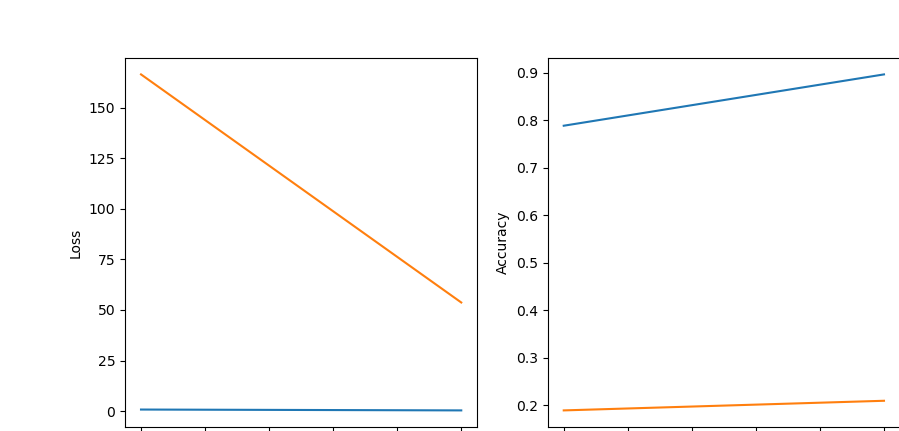

EPOCH1
ADAM_TRAIN_Loss: 0.7847, TRAIN_ACC: 0.7887
GWDC_TRAIN_Loss: 166.4673, TRAIN_ACC: 0.1892
ADAM_TEST_Loss: 0.3909, TEST_ACC: 0.8922
GWDC_TEST_Loss: 69.4535, TEST_ACC: 0.2099
EPOCH2
ADAM_TRAIN_Loss: 0.3616, TRAIN_ACC: 0.8968
GWDC_TRAIN_Loss: 53.7059, TRAIN_ACC: 0.2094
ADAM_TEST_Loss: 0.3183, TEST_ACC: 0.9080
GWDC_TEST_Loss: 40.8779, TEST_ACC: 0.2206


KeyboardInterrupt: 

In [5]:
%matplotlib notebook
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import DataLoader
from GWDC import GWDC
from ADAM import ADAM
import os
import math
import numpy as np
from plot import dynamicplot

EPOCH = 50
BATCH_SIZE = 20
LR = 0.01
ROOT = "./data/mnist"
DOWNLOAD_MNIST = False
if not os.path.exists(ROOT):
    DOWNLOAD_MNIST = True
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Device is '+torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print('Device is cpu')

trans=torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5],[0.5])
    ]
)


#dataloader
train_data=torchvision.datasets.MNIST(
    root=ROOT,
    train=True,
    transform=trans,
    download=DOWNLOAD_MNIST
)

train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
 
test_data=torchvision.datasets.MNIST(
    root=ROOT,
    train=False,
    transform=trans,
    download=DOWNLOAD_MNIST
)
test_loader=DataLoader(test_data,batch_size=len(test_data),shuffle=False)
 
#NN 
#net=torch.nn.Sequential(
#    nn.Linear(28*28,30),
#    nn.ReLU()
#    nn.Linear(30,10)
#)

#NN 2
ADAMnet=torch.nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
GWDCnet=torch.nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
ADAMnet = ADAMnet.to(DEVICE)
GWDCnet = GWDCnet.to(DEVICE)
#nets = [ADAMnet, DWGCnet]
#net.to(DEVICE)

loss_function=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(net.parameters(),lr=LR)
optimADAM = ADAM(ADAMnet.parameters())

optimGWDC = GWDC(GWDCnet.parameters())
#optimizers = [optimADAM, optimGWDC]
print("Start training")
DP = dynamicplot()
DP.plotdefine()
for ep in range(EPOCH):
    batch_num = 0
    train_loss1 = 0
    train_loss2 = 0
    test_batch_num = 0
    test_loss1 = 0
    test_loss2 = 0
    train1_num_correct=0
    train2_num_correct=0
    test1_num_correct=0
    test2_num_correct=0
    for data in train_loader:#for every batch
        
        img,label=data
        img = img.view(img.size(0), -1)
         
        
        img=img.to(DEVICE)
        label=label.to(DEVICE)
 
        out1=ADAMnet(img)
        out2=GWDCnet(img)
        loss1=loss_function(out1,label)
        loss2=loss_function(out2,label)
        optimADAM.zero_grad()
        optimGWDC.zero_grad()
        loss1.backward()
        loss2.backward()
        optimADAM.step()
        optimGWDC.step()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        batch_num += 1
        _,prediction1=torch.max(out1,1)
        _,prediction2=torch.max(out2,1)
        train1_num_correct+=(prediction1==label).sum()
        train2_num_correct+=(prediction2==label).sum()
    print('EPOCH%d'%(ep+1))
    train1_accuracy=train1_num_correct.cpu().numpy()/len(train_data)
    train2_accuracy=train2_num_correct.cpu().numpy()/len(train_data)
    print('ADAM_TRAIN_Loss: %.4f, TRAIN_ACC: %.4f'%(train_loss1/batch_num,train1_accuracy))
    print('GWDC_TRAIN_Loss: %.4f, TRAIN_ACC: %.4f'%(train_loss2/batch_num,train2_accuracy))
    
    for data in test_loader:
        img,label=data
        img = img.view(img.size(0), -1)
 
        img=img.to(DEVICE)
        label=label.to(DEVICE)
 
        out1=ADAMnet(img)
        out2=GWDCnet(img)
        loss1=loss_function(out1,label)
        loss2=loss_function(out2,label)
        test_loss1 += loss1.item()
        test_loss2 += loss2.item()
        test_batch_num += 1
        _,prediction1=torch.max(out1,1)
        _,prediction2=torch.max(out2,1)
        test1_num_correct+=(prediction1==label).sum()
        test2_num_correct+=(prediction2==label).sum()
    accuracy1=test1_num_correct.cpu().numpy()/len(test_data)
    accuracy2=test2_num_correct.cpu().numpy()/len(test_data)
    print("ADAM_TEST_Loss: %.4f, TEST_ACC: %.4f"%(test_loss1/test_batch_num,accuracy1))
    print("GWDC_TEST_Loss: %.4f, TEST_ACC: %.4f"%(test_loss2/test_batch_num,accuracy2))
    DP.showplot(train_loss1/batch_num,train1_accuracy,train_loss2/batch_num,train2_accuracy)
